In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
from scipy import stats
from sklearn.decomposition import PCA

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth',None)
%matplotlib inline

In [25]:
# Save the merged dataframe to a CSV file
df = pd.read_csv('/content/gdrive/Shareddrives/LMN/LMN_Group_Project/Datasets/Energy Consumption and Renewables Generation/merged_df.csv')

In [26]:
col_names = {'unrate': 'Unemployment rate',
'psr': 'Personal savings rate',
'm2': 'M2 money supply',
'dspic': 'Personal consumption expenditures (PCE) price index excluding food and energy',
'pce': 'Personal consumption expenditures',
'reer': 'Real effective exchange rate',
'ir': '3-Month Treasury Bill: Secondary Market Rate',
'ffer': 'Federal Funds Rate - Upper Bound',
'tcs': 'Consumer Confidence Index',
'indpro': 'Industrial Production Index',
'ccpi': 'Consumer Price Index for All Urban Consumers: All Items'}

df.rename(columns=col_names, inplace=True)

In [27]:
df.dropna(inplace=True)

## Convert Date to Year, Month and Season column

In [28]:
# Convert date column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Create new features for year, month and day
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month

# Create feature for season (based on month)
df['season'] = np.where(df['month'].isin([12, 1, 2]), 'Winter',
                         np.where(df['month'].isin([3, 4, 5]), 'Spring',
                                  np.where(df['month'].isin([6, 7, 8]), 'Summer',
                                           np.where(df['month'].isin([9, 10, 11]), 'Fall', 'Unknown'))))

## Convert tmax, tmin to temperature_range and add lag and rolling average features for it

In [29]:
# Convert to temperature_range
df['temperature_range'] = df['tmax'] - df['tmin']

# Create lag feature
df['temperature_range_lag1'] = df['temperature_range'].shift(1)

# Create moving average feature
df['temperature_range_rolling_mean12'] = df['temperature_range'].rolling(window=12).mean()

df.drop(['tmax', 'tmin'], axis=1, inplace=True)

## Add lag and moving average features for precipitation

In [30]:
# Create lag feature
df['prcp_lag1'] = df['prcp'].shift(1)

# Create moving average feature
df['prcp_mean12'] = df['prcp'].rolling(window=12).mean()

## Add lag and moving average features for Total Energy Sales (MWh)

In [31]:
# Create lag features
df['Total Energy Sales (MWh)_lag1'] = df['Total Energy Sales (MWh)'].shift(1)
df['Total Energy Sales (MWh)_lag2'] = df['Total Energy Sales (MWh)'].shift(2)
df['Total Energy Sales (MWh)_lag3'] = df['Total Energy Sales (MWh)'].shift(3)

# Create moving average features
df['Total Energy Sales (MWh)_rolling_mean3'] = df['Total Energy Sales (MWh)'].rolling(window=3).mean()
df['Total Energy Sales (MWh)_rolling_mean6'] = df['Total Energy Sales (MWh)'].rolling(window=6).mean()
df['Total Energy Sales (MWh)_rolling_mean12'] = df['Total Energy Sales (MWh)'].rolling(window=12).mean()

## Add lag and moving average features for Total Renewable Energy Production

In [32]:
# Create lag features
df['Total Renewable Energy Production_lag1'] = df['Total Renewable Energy Production'].shift(1)
df['Total Renewable Energy Production_lag2'] = df['Total Renewable Energy Production'].shift(2)
df['Total Renewable Energy Production_lag3'] = df['Total Renewable Energy Production'].shift(3)

# Create moving average features for renewable energy production and consumption variables
df['Total Renewable Energy Production_rolling_mean3'] = df['Total Renewable Energy Production'].rolling(window=3).mean()
df['Total Renewable Energy Production_rolling_mean6'] = df['Total Renewable Energy Production'].rolling(window=6).mean()
df['Total Renewable Energy Production_rolling_mean12'] = df['Total Renewable Energy Production'].rolling(window=12).mean()

## Add interaction terms based on EDA

In [33]:
# Interaction terms for consumption and production variables
df['energy_consumption_renewable_interaction'] = df['Total Energy Sales (MWh)'] * df['Total Renewable Energy Production']
df['energy_consumption_traditional_interaction'] = df['Total Energy Sales (MWh)'] * df['Total Fossil Fuels Production']

# Interaction term for consumption and industrial index
df['energy_consumption_industrial_interaction'] = df['Total Energy Sales (MWh)'] * df['Industrial Production Index']

## Correlation between energy consumption fields

<AxesSubplot:>

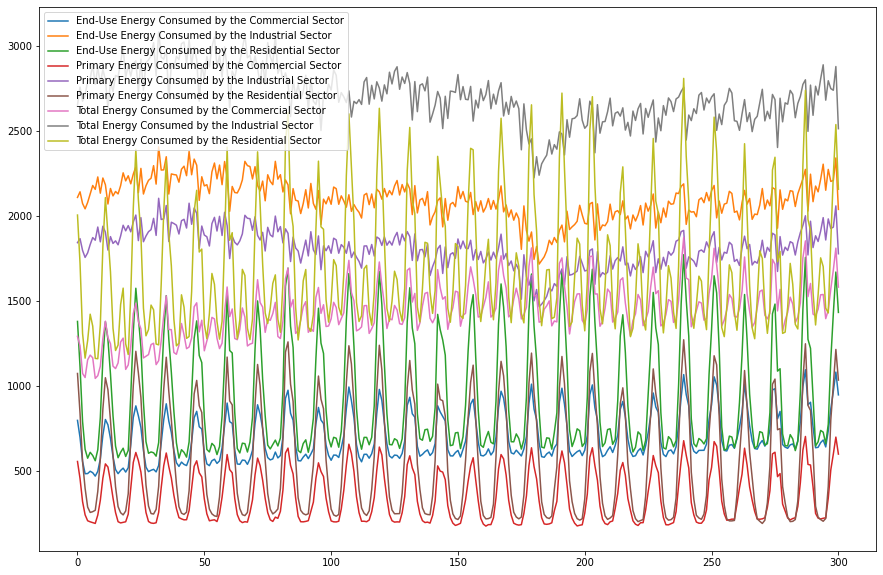

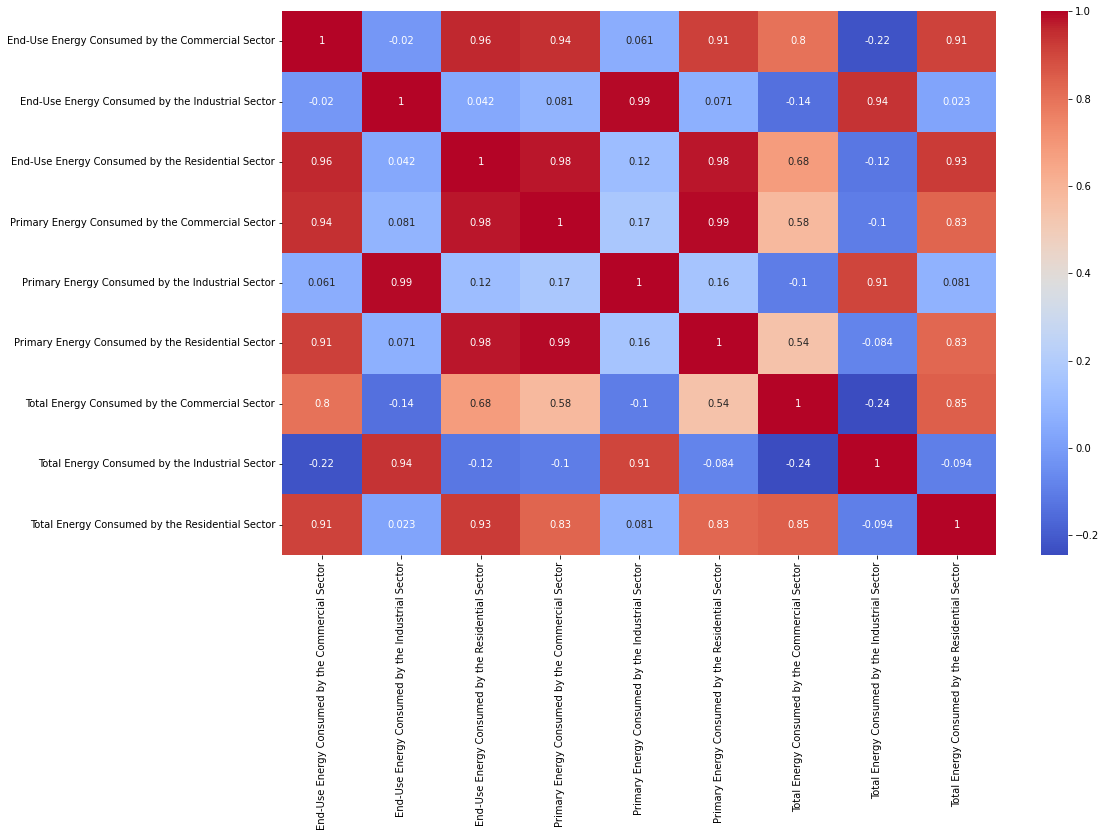

In [34]:
cols = [
 'End-Use Energy Consumed by the Commercial Sector',
 'End-Use Energy Consumed by the Industrial Sector',
 'End-Use Energy Consumed by the Residential Sector',
 'Primary Energy Consumed by the Commercial Sector',
 'Primary Energy Consumed by the Industrial Sector',
 'Primary Energy Consumed by the Residential Sector',
 'Total Energy Consumed by the Commercial Sector',
 'Total Energy Consumed by the Industrial Sector',
 'Total Energy Consumed by the Residential Sector']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 10))

for col in cols:
    ax.plot(df.sort_values('DATE')[col], label=col)

# Show the legend
ax.legend()

# Correlation matrix
corr = df[cols].corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')



As can be seen from the heatmap, there is quite a bit of correlation between these fields and hence would not be wise to use them in the model. We will use PCA to combine them into one column.

## PCA to combine all energy consumption related fields into one

In [35]:
cols = [
 'End-Use Energy Consumed by the Commercial Sector',
 'End-Use Energy Consumed by the Industrial Sector',
 'End-Use Energy Consumed by the Residential Sector',
 'Primary Energy Consumed by the Commercial Sector',
 'Primary Energy Consumed by the Industrial Sector',
 'Primary Energy Consumed by the Residential Sector',
 'Total Energy Consumed by the Commercial Sector',
 'Total Energy Consumed by the Industrial Sector',
 'Total Energy Consumed by the Residential Sector']

# Instantiate a PCA object
pca = PCA()

# Fit and transform the data
X_pca = pca.fit_transform(df[cols])

# variance explained by each component
variance_explained = pca.explained_variance_ratio_

# cumulative variance explained by components
cumulative_variance_explained = np.cumsum(variance_explained)

cumulative_variance_explained

array([0.8177123 , 0.92333136, 0.98707244, 0.99675836, 0.9996219 ,
       0.99989825, 0.9999953 , 0.99999913, 1.        ])

## Removing all the energy consumption columns from the data

In [36]:
cols = ['Commercial Sector Electrical System Energy Losses',
 'Electricity Sales to Ultimate Customers in the Commercial Sector',
 'Electricity Sales to Ultimate Customers in the Industrial Sector',
 'Electricity Sales to Ultimate Customers in the Residential Sector',
 'End-Use Energy Consumed by the Commercial Sector',
 'End-Use Energy Consumed by the Industrial Sector',
 'End-Use Energy Consumed by the Residential Sector',
 'Industrial Sector Electrical System Energy Losses',
 'Primary Energy Consumed by the Commercial Sector',
 'Primary Energy Consumed by the Industrial Sector',
 'Primary Energy Consumed by the Residential Sector',
 'Residential Sector Electrical System Energy Losses',
 'Total Energy Consumed by the Commercial Sector',
 'Total Energy Consumed by the Industrial Sector',
 'Total Energy Consumed by the Residential Sector', 
 'Residential Sales (MWh)',
 'Commercial Sales (MWh)',
 'Industrial Sales (MWh)',
 'Peak Demand (MW)']

new_df = df.drop(cols, axis=1)

## A look at the distribution of various energy consumption variables: PCA component and Total Energy Sales (MWh)

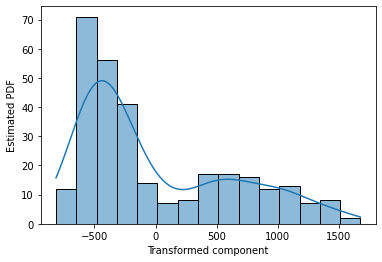

In [52]:
pca_component = [row[0] for row in X_pca]

sns.histplot(pca_component, kde=True, bins=15)
plt.xlabel('Transformed component')
plt.ylabel('Estimated PDF')
plt.show()

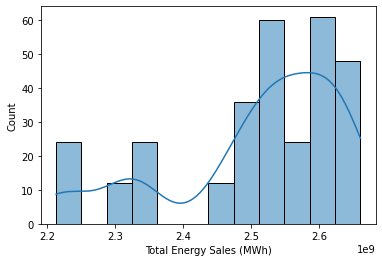

In [38]:
sns.histplot(df['Total Energy Sales (MWh)'], kde=True)
plt.show()

## A look at the distribution of Total Renewable Energy Production

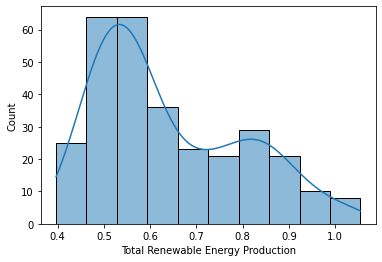

In [51]:
sns.histplot(df['Total Renewable Energy Production'], kde=True)
plt.show()

## Function to get list of exponential family distributions that fit

In [54]:
def get_exponential_family_distributions(x):
    """
    Returns a list of all the exponential family distributions that fit the input variable x.
    If no distributions fit, returns an empty list.
    """
    # List of exponential family distributions from scipy.stats
    distributions = [
        stats.norm,          # normal distribution
        stats.gamma,         # gamma distribution
        stats.expon,         # exponential distribution
        stats.beta,          # beta distribution
        stats.poisson,       # Poisson distribution
        stats.binom,         # binomial distribution
        stats.nbinom,        # negative binomial distribution
        stats.geom,          # geometric distribution
        stats.lognorm,       # log-normal distribution
        stats.uniform,       # uniform distribution
        stats.invgamma,      # inverse gamma distribution
        stats.invgauss,      # inverse Gaussian distribution
        stats.multinomial,   # multinomial distribution
        stats.multivariate_normal  # multivariate normal distribution
    ]
    
    # List to store the distributions that fit the input variable
    fitted_distributions = []
    
    # Test if x fits each of the distributions in the list
    for dist in distributions:
        try:
            params = dist.fit(x)
            if params is not None:
                fitted_distributions.append(dist)
        except ValueError:
            pass
    
    return fitted_distributions


## Print all pairs of columns with correlation higher than 0.9 

In [39]:
# Compute the correlation matrix of all columns in the dataframe
corr_matrix = new_df.corr().abs()

# Stack the correlation matrix to create a dataframe of pairwise correlations
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)

# Select the pairs of variables that have a correlation coefficient greater than 0.8 (or less than -0.8)
high_corr_pairs = corr_pairs[(corr_pairs > 0.9) & (corr_pairs < 1.0)]

# Print the list of variables that have high correlation with other variables
high_corr_pairs

Consumer Price Index for All Urban Consumers: All Items  year                                                       0.998672
year                                                     Consumer Price Index for All Urban Consumers: All Items    0.998672
Consumer Price Index for All Urban Consumers: All Items  Personal consumption expenditures                          0.997942
Personal consumption expenditures                        Consumer Price Index for All Urban Consumers: All Items    0.997942
Total Energy Sales (MWh)_lag1                            Total Energy Sales (MWh)_rolling_mean3                     0.997825
                                                                                                                      ...   
Wind Energy Production                                   Natural Gas Plant Liquids Production                       0.900562
Industrial Production Index                              Total Energy Sales (MWh)_lag2                              0.900482


## Visualizing the Correlations

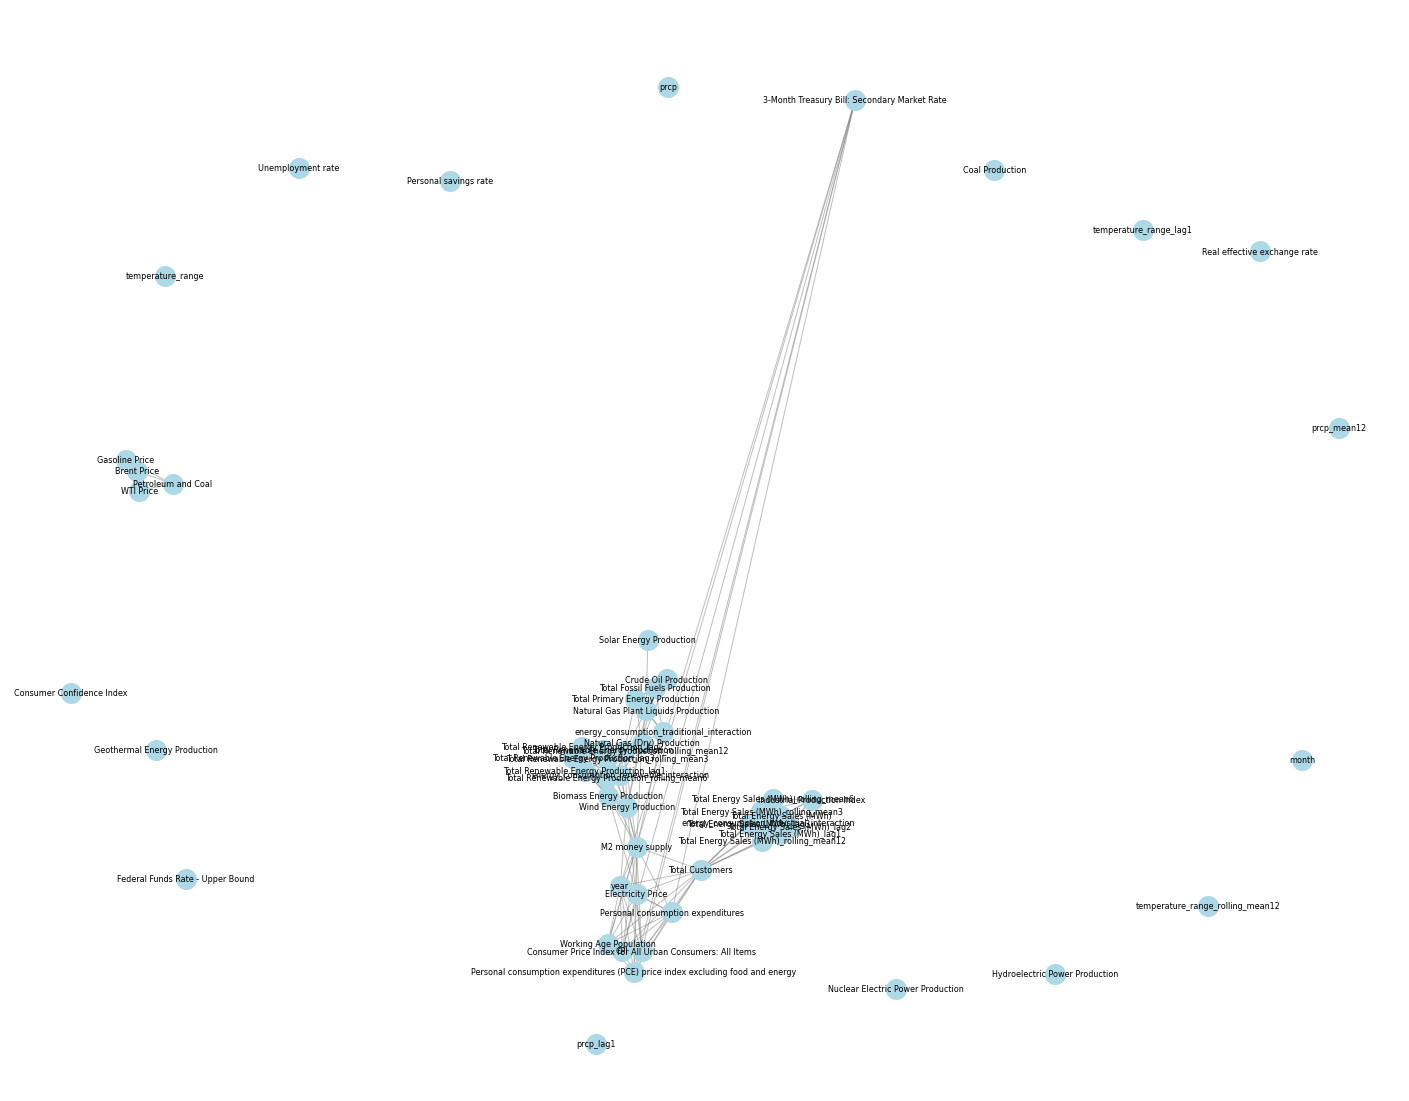

In [40]:
plt.figure(figsize=(25,20))


# create empty graph
G = nx.Graph()

temp_df = new_df.drop(['DATE', 'season'], axis=1)

# Create a list of columns to use as nodes in the network graph
nodes = list(temp_df.columns)

# Add the nodes to the graph
G.add_nodes_from(nodes)

# Loop through each pair of nodes and calculate the correlation
for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
        corr = temp_df[nodes[i]].corr(temp_df[nodes[j]])
        
        # Add an edge to the graph if the correlation is above a certain threshold
        if abs(corr) > 0.9:
            G.add_edge(nodes[i], nodes[j], weight=corr)

# Define the layout of the graph using the spring layout algorithm
pos = nx.spring_layout(G, k=0.15, seed=42)

# Draw the nodes and edges of the graph
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=400)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# Add labels to the nodes
labels = {node: node for node in nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_family='sans-serif')

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Display the graph
plt.axis('off')
plt.show()

In [41]:
list(new_df.columns)

['prcp',
 'Total Energy Sales (MWh)',
 'Total Customers',
 'Gasoline Price',
 'Coal Production',
 'Natural Gas (Dry) Production',
 'Crude Oil Production',
 'Natural Gas Plant Liquids Production',
 'Total Fossil Fuels Production',
 'Nuclear Electric Power Production',
 'Hydroelectric Power Production',
 'Geothermal Energy Production',
 'Solar Energy Production',
 'Wind Energy Production',
 'Biomass Energy Production',
 'Total Renewable Energy Production',
 'Total Primary Energy Production',
 'Electricity Price',
 'Petroleum and Coal',
 'CPI',
 'Working Age Population',
 'Unemployment rate',
 'Personal savings rate',
 'M2 money supply',
 'Personal consumption expenditures (PCE) price index excluding food and energy',
 'Personal consumption expenditures',
 'Real effective exchange rate',
 '3-Month Treasury Bill: Secondary Market Rate',
 'Federal Funds Rate - Upper Bound',
 'Consumer Confidence Index',
 'Industrial Production Index',
 'Consumer Price Index for All Urban Consumers: All Item

In [42]:
# Save the merged dataframe to a CSV file
#new_df.to_csv('/content/drive/Shareddrives/LMN/LMN_Group_Project/Datasets/Energy Consumption and Renewables Generation/feature_engineered_df.csv', index=False)

## Append the first pca component to the new df

In [43]:
new_df['Energy Consumption PCA Component'] = pca_component

## Visualizing energy consumption against temperature range

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temperature_range', ylabel='Total Energy Sales (MWh)'>

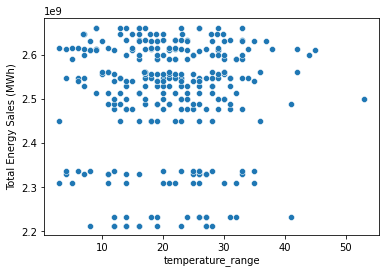

In [46]:
sns.scatterplot(new_df['temperature_range'], new_df['Total Energy Sales (MWh)'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temperature_range', ylabel='Energy Consumption PCA Component'>

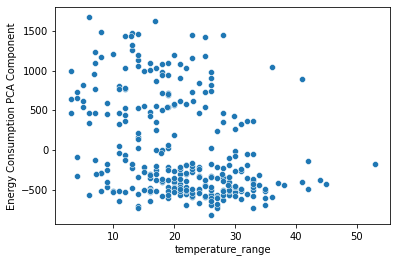

In [47]:
sns.scatterplot(new_df['temperature_range'], new_df['Energy Consumption PCA Component'])

## Visualizing energy consumption against precipitation

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prcp', ylabel='Total Energy Sales (MWh)'>

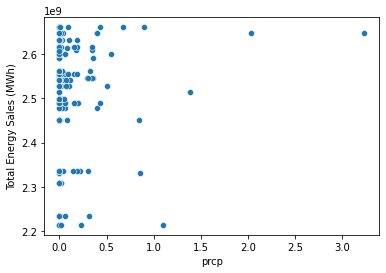

In [48]:
sns.scatterplot(new_df['prcp'], new_df['Total Energy Sales (MWh)'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='prcp', ylabel='Energy Consumption PCA Component'>

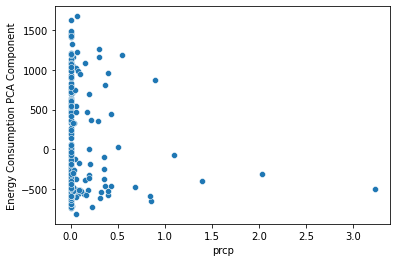

In [49]:
sns.scatterplot(new_df['prcp'], new_df['Energy Consumption PCA Component'])

## Visualizing Renewable Energy Generation against temperature and precipitation

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temperature_range', ylabel='Total Renewable Energy Production'>

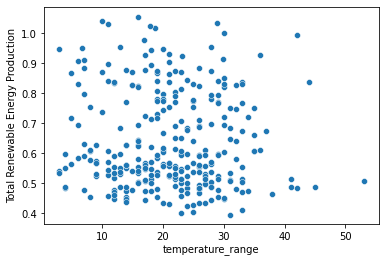

In [50]:
sns.scatterplot(new_df['temperature_range'], new_df['Total Renewable Energy Production'])